In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import numpy as np
import pandas as pd
import yaml
import pydotplus
import ast

In [72]:
%run ./src/database.py
%run ./src/util.py
%run ./src/data_preprocessing.py
%run ./src/feature_engineering.py
%run ./src/visualisation.py
%run ./src/model_build.py

In [73]:
YAML_FILEPATHNAME = "./config.yaml"
PRE_CRUISE_DB = 0
POST_CRUISE_DB = 1
IS_NOTEBOOK = True

# Read yaml config and data

In [74]:
# Read YAML file
yaml_data = read_yaml(YAML_FILEPATHNAME)
DISPLAY_STUB = yaml_data['display_stub']
DATA_PATH = yaml_data['data_path']
TEST_SIZE = yaml_data['test_size']
RANDOM_STATE = yaml_data['random_state']
TARGET_VARIABLE = yaml_data['target_variable']
DB_INFO = yaml_data['databases']
COMPOSITE_FIELD_INFO = yaml_data['composite_fields_to_split']
ID_FIELDS = ast.literal_eval(yaml_data['ID_columns'])
DATETIME_FIELD_INFO = yaml_data['convert_obj_datetime']
NUMERIC_FIELD_INFO = yaml_data['convert_obj_numeric']
MISSING_VAL_THRESHOLD =  yaml_data['pct_missing_threshold']
CONTINUOUS_VARIABLE = ast.literal_eval(yaml_data['continuous_variables'])
DIRTY_DATA_INFO = yaml_data['dirty_data_setting']
VALID_DATA_INFO = yaml_data['valid_data_setting']
NON_NUMERIC_COL = yaml_data['non_numeric_cols']
DATE_YYYY_INFO = yaml_data['convert_date_yyyy']
IMPUTE_MISSING_VALUE_INFO = yaml_data['impute_missing_value']
OHE_FIELDS = ast.literal_eval(yaml_data['one_hot_encode'])

In [75]:
# Read Pre_cruise data
df_pre_cruise = db_read(DATA_PATH, DB_INFO[PRE_CRUISE_DB])

In [76]:
# Read Post_cruise data
df_post_cruise = db_read(DATA_PATH, DB_INFO[POST_CRUISE_DB])

# Preprocessing

In [77]:
# Merge Pre_cruise and Post_cruise to form df_cruise with Index as the key
df_cruise = db_merge_db (df_pre_cruise, df_post_cruise)

In [78]:
dp = DataProcessing(df_cruise, DISPLAY_STUB)

In [79]:
# Replace all np.nan to None
dp.replace_nan_none()

In [80]:
# Split composite field
dp.split_composite_field(COMPOSITE_FIELD_INFO)

In [81]:
# Remove IDs columns as in general they will have no predictive power
dp.rm_id_cols(ID_FIELDS)

In [82]:
# Column pruning due to high missing values.
dp.rm_cols_high_missing(MISSING_VAL_THRESHOLD)

In [83]:
# Convert fields from Object to Datetime
dp.obj_to_datetime(DATETIME_FIELD_INFO)

In [84]:
# Convert fields from Object to Numeric 
dp.numeric_conversion(NUMERIC_FIELD_INFO)

In [85]:
# Remove of rows from Target Variable 
dp.rm_rows_target_var(TARGET_VARIABLE)

In [86]:
# Removal of rows from Continuous variable which has missing value 
dp.remove_missing(CONTINUOUS_VARIABLE)

In [87]:
# Dirty Data Cleansing
dp.dirty_data_processing(DIRTY_DATA_INFO)

In [88]:
# Restriction of Column vales
dp.valid_data_processing(VALID_DATA_INFO)

In [89]:
var_name='Cleanliness'

In [90]:
# dp_data=dp.get_dataframe()
# print(dp_data[var_name].unique())
# vs_countplot(dp_data,[var_name], True)
# print(dp_data[var_name].isnull().sum())

In [91]:
dp.impute_missing_value_info(IMPUTE_MISSING_VALUE_INFO)
# dp.impute_missing_value(impute_type="random", col_list=['Gender','Online Check-in','Baggage handling','Cleanliness'])
# dp.impute_missing_value(impute_type="mode", col_list=['Cruise Name','Onboard Wifi Service', 'Ease of Online booking',
#                                                       'Embarkation/Disembarkation time convenient', 'Gate location',
#                                                      'Onboard Dining Service','Cabin Comfort','Onboard Entertainment',
#                                                      'Cabin service','Port Check-in Service','Onboard Service'])
# dp.impute_missing_value(impute_type="mean", col_list=['Distance'])

In [92]:
dp_data=dp.get_dataframe()
# print(dp_data[var_name].unique())
# vs_countplot(dp_data,[var_name], True)
print(dp_data.isnull().sum())
print("There are {} rows".format(dp_data.shape[0]))

Gender                                         9343
Date of Birth                                     0
Onboard Wifi Service                          13526
Embarkation/Disembarkation time convenient    14979
Ease of Online booking                        16233
Gate location                                 11906
Logging                                           0
Onboard Dining Service                        11637
Online Check-in                               12777
Cabin Comfort                                 14090
Onboard Entertainment                         11013
Cabin service                                  9597
Baggage handling                              14133
Port Check-in Service                          9940
Onboard Service                               12760
Cleanliness                                   12777
Cruise Name                                   11284
Ticket Type                                       0
Dining                                            0
Source      

In [93]:
# Label encode non-numeric categorical columns to get numeric values
dp.label_encoder(NON_NUMERIC_COL)

In [94]:
# Derive year from date column to enhance model efficiency, mitigate noise
dp.yyyy_from_date(DATE_YYYY_INFO)

# Feature Engineering

In [95]:
fe = feature_engineering(dp.get_dataframe())

In [96]:
temp1 = fe.get_dataframe()

In [97]:
temp1.head(5)

,Gender,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,...,Cleanliness,Cruise Name,Ticket Type,Dining,Source,Traffic,Distance,Dist_Metrics,Year of Birth,Year of Logging
index,,,,,,,,,,,,,,,,,,,,,
3,0,5,4.0,4.0,4.0,4,4.0,4.0,2,None,...,4.0,1,0,0,0,0,280.0,0,1970,2023
4,1,4,4.0,2.0,None,3,2.0,None,3,3.0,...,None,1,2,1,0,0,1145.0,1,1960,2023
6,1,4,5.0,3.0,3.0,5,None,4.0,5,None,...,4.0,1,2,1,0,1,607.0,0,1986,2023
8,0,1,4.0,None,4.0,5,1.0,2.0,1,5.0,...,1.0,0,0,0,0,1,<NA>,2,1981,2023
9,0,3,None,None,1.0,4,None,3.0,2,4.0,...,3.0,2,1,0,0,0,<NA>,2,1980,2023


In [98]:
fe.one_hot_key_encode(OHE_FIELDS)
# fe.one_hot_key_encode(["Traffic"])

In [99]:
dp.get_dataframe()

,Gender,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,...,Cleanliness,Cruise Name,Ticket Type,Dining,Source,Traffic,Distance,Dist_Metrics,Year of Birth,Year of Logging
index,,,,,,,,,,,,,,,,,,,,,
3,0,5,4.0,4.0,4.0,4,4.0,4.0,2,None,...,4.0,1,0,0,0,0,280.0,0,1970,2023
4,1,4,4.0,2.0,None,3,2.0,None,3,3.0,...,None,1,2,1,0,0,1145.0,1,1960,2023
6,1,4,5.0,3.0,3.0,5,None,4.0,5,None,...,4.0,1,2,1,0,1,607.0,0,1986,2023
8,0,1,4.0,None,4.0,5,1.0,2.0,1,5.0,...,1.0,0,0,0,0,1,<NA>,2,1981,2023
9,0,3,None,None,1.0,4,None,3.0,2,4.0,...,3.0,2,1,0,0,0,<NA>,2,1980,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133734,0,0,1.0,1.0,1.0,3,4.0,4.0,2,2.0,...,2.0,2,1,1,0,1,1900.0,0,1979,2023
133739,0,2,5.0,2.0,1.0,2,4.0,5.0,5,4.0,...,4.0,0,2,0,0,0,2717.0,0,1962,2023
133740,1,4,3.0,3.0,3.0,4,None,3.0,4,3.0,...,3.0,2,2,1,0,0,<NA>,2,1987,2023


In [100]:
# Standardise distance by converting Mile to KM
fe.convert_miles_to_KM("Distance")

In [101]:
# Derive Age from Year of Birth and Year of Logging
fe.calc_year_diff('Year of Logging', 'Year of Birth', 'Age')

In [102]:
# Compute number of column
# fe.denote_missing_col()

#### Gender

In [103]:
fe.impute_missing_value(impute_type="mean")

# Model Building

In [104]:
# hyperparameter_dict = {
# }
# dtc = Decision_Tree_Classifier(fe.get_dataframe(), TARGET_VARIABLE, hyperparameter_dict, TEST_SIZE, RANDOM_STATE, IS_NOTEBOOK)
# param_grid = {'max_depth':[3,5,7,9,10],
#               'criterion':['gini','entropy'],
#               'max_features': ['sqrt','log2'],
#               'min_samples_split':[2,4,6]
#              }
# dtc.GridSearchCV(param_grid, 4)


Classification Report 
Train 
              precision    recall  f1-score   support

           0       0.77      0.72      0.74     35371
           1       0.78      0.71      0.74     35371
           2       0.61      0.70      0.65     35371

    accuracy                           0.71    106113
   macro avg       0.72      0.71      0.71    106113
weighted avg       0.72      0.71      0.71    106113

Test 
              precision    recall  f1-score   support

           0       0.11      0.16      0.13      1357
           1       0.81      0.69      0.75      8843
           2       0.66      0.72      0.69      8344

    accuracy                           0.66     18544
   macro avg       0.53      0.52      0.52     18544
weighted avg       0.69      0.66      0.67     18544


Confusion Metric
Train


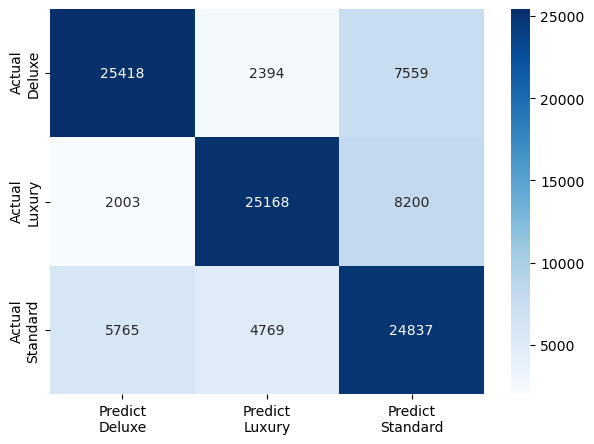

Test


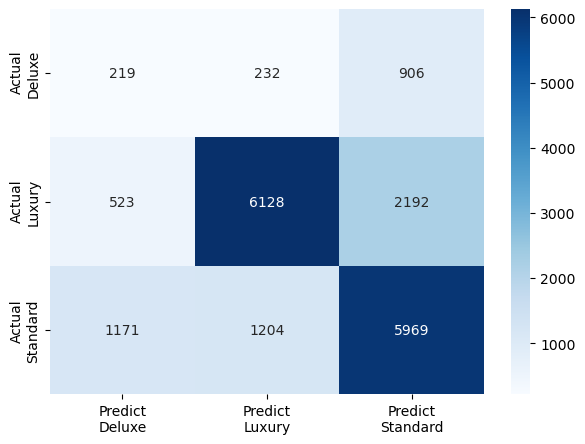


Performance Metrics
Train 
Test Accuracy: 0.7108
Test Precision: 0.7108
Test Recall: 0.7108
Test 
Test Accuracy: 0.6642
Test Precision: 0.6642
Test Recall: 0.6642
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.277083 to fit

(process:25052): GLib-GIO-WARNING **: 18:11:04.204: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.8.3.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs

(process:25052): GLib-GIO-WARNING **: 18:11:04.283: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2310.54.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs



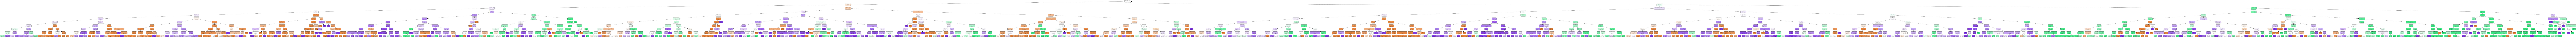

In [105]:
hyperparameter_dict = {
    'max_depth':10, 
    'max_features':'sqrt'
}
dtc = Decision_Tree_Classifier(fe.get_dataframe(), TARGET_VARIABLE, hyperparameter_dict, TEST_SIZE, RANDOM_STATE, IS_NOTEBOOK)
dtc_train = dtc.model_processing()
X = dtc.return_X()
dot_data = export_graphviz(dtc_train, out_file=None, feature_names=list(X.columns.values), 
                        class_names=['Delxue', 'Luxury', 'Standard'], rounded=True, filled=True)
from IPython.display import Image, display
graph = pydotplus.graph_from_dot_data(dot_data)
# Show graph
Image(graph.create_png()) 

In [ ]:
# dtc = Decision_Tree(fe.get_dataframe())
# X, y = dtc.prepare_data(TARGET_VARIABLE)
# hyperparameter_dict = {
# }
# dtc.model_processing(X, y, TEST_SIZE, RANDOM_STATE, hyperparameter_dict, IS_NOTEBOOK)

In [ ]:

# columns = X_train.columns
# os_data_X,os_data_y=os.fit_resample(X_train, y_train)
# os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
# os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])


# Model Evaluation